<a href="https://colab.research.google.com/github/iliaxant/HR_Extraction_from_Video/blob/main/HR_Extraction_from_Video.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Εκτίμηση καρδιακής συχνότητας από βίντεο (πρόσωπο ή δάχτυλο) - Ψηφιακή Επεξεργασία Εικόνας**

## Εξαμηνιαία Εργασία - Ακαδημαικό έτος 2025-2026

## Ηλίας Ξανθόπουλος 58545

## GitHub Repo: https://github.com/iliaxant/HR_Extraction_from_Video

## **Part 0**: Set-Up

1) Mount Google drive and load a subject of dataset. (Change zip_path to match your zip file directory).

In [1]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import zipfile

# Subject 2, 6, 7, 19, 21, 28 and 29 data not available either due to data share
# disagreement or due to technical issues
zip_path = '/content/drive/MyDrive/DIP/HR_extraction/subject45.zip'
zip_ref = zipfile.ZipFile(zip_path, 'r')
zip_ref.extractall('/content')
zip_ref.close()

print("Data unzipped successfully to /content directory.")

Data unzipped successfully to /content directory.


2) Install and import libraries.

In [3]:
from google.colab import drive
import zipfile
import os

import cv2
from google.colab.patches import cv2_imshow
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from scipy.signal import butter, filtfilt, stft
from scipy.fft import fft, fftfreq

## **Part 1**: Data Preparation

1) Define all subject data directories. Print useful information about the subject video and print the first frame as a sample.

============ Video Info ============

Resolution:       640 x 480
Frame Rate (FPS): 29.951
Frame Count:      2032
Duration:         1:07.845 (67.845s)




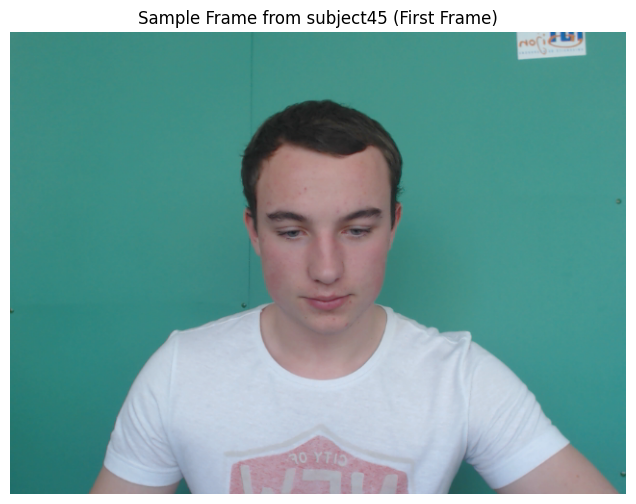

In [4]:
# Input subject num
# ----------------------
num = '45'
# ----------------------

subject_path = f'/content/subject{num}'
video_path = os.path.join(subject_path, 'vid.avi')
gt_path = os.path.join(subject_path, 'ground_truth.txt')


cap = cv2.VideoCapture(video_path)

ret, frame_bgr = cap.read()

frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
fps = cap.get(cv2.CAP_PROP_FPS)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
video_duration_secs = frame_count / fps

cap.release()

frame_rgb = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2RGB)

minutes = int(video_duration_secs // 60)
seconds = int(video_duration_secs % 60)
milliseconds = round((video_duration_secs - int(video_duration_secs)) * 1000)

video_duration_full_time = f"{minutes}:{seconds:02d}.{milliseconds:03d}"

print("============ Video Info ============\n")

print(f"Resolution:       {width} x {height}")
print(f"Frame Rate (FPS): {fps:.3f}")
print(f"Frame Count:      {frame_count}")
print(f"Duration:         {video_duration_full_time} ({video_duration_secs:.3f}s)\n")

print("====================================\n")

plt.figure(figsize=(8, 6))
plt.imshow(frame_rgb)
plt.title(f"Sample Frame from subject{num} (First Frame)")
plt.axis('off')
plt.show()

2) Print all useful Ground Truth information. Plot the PPG signal and HR values over a specified time window.

========= Ground Truth Info =========

PPG signal/Time/HR samples: 2032
Time range: 0.000s to 67.828s
Sampling rate (estimated): 29.943 Hz

PPG signal (first 10 samples): [-0.804 -0.898 -0.851 -0.772 -0.873 -1.036 -1.276 -1.452 -1.496 -1.464]
PPG signal mean: -0.000
PPG signal Standard Deviation: 0.985

Time in seconds (first 10 samples): [0.    0.033 0.066 0.099 0.132 0.165 0.202 0.233 0.275 0.297]
Difference of sampling times (first 10 values): [0.033 0.033 0.033 0.033 0.033 0.037 0.031 0.042 0.022 0.035]
Difference of sampling times mean: 0.033
Difference of sampling times Standard Deviation: 0.008

HR in bpm (first 10 samples): [96 96 96 96 96 96 96 96 96 96]
HR mean: 110.820
HR Standard Deviation: 5.009




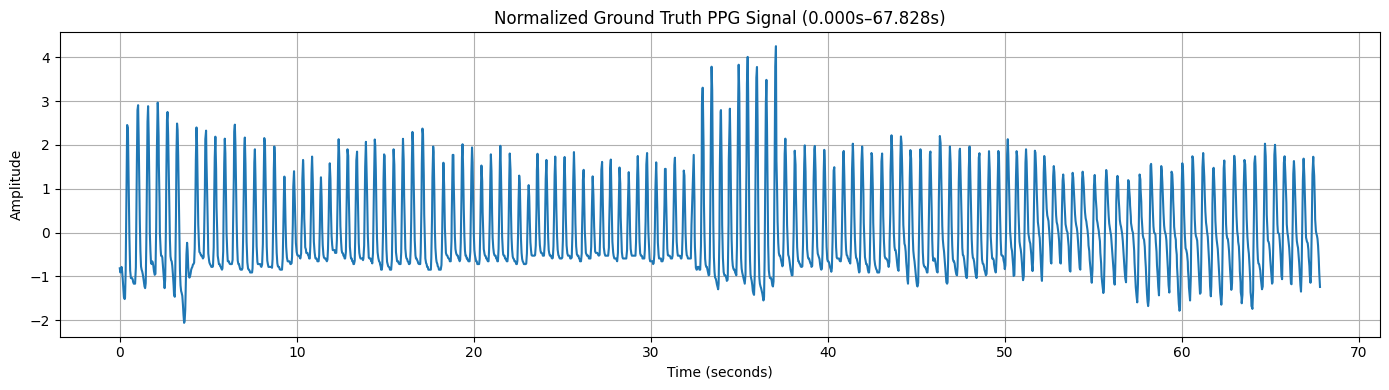

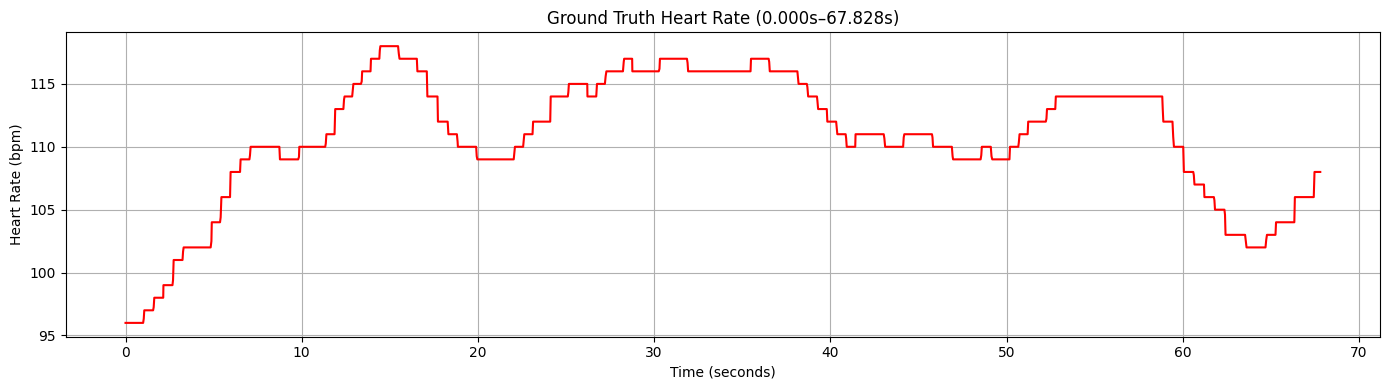

In [5]:
gt_data = np.loadtxt(gt_path)

gt_ppg = gt_data[0, :]
gt_hr = gt_data[1, :]
gt_time = gt_data[2, :]


# Input start time and duration (in seconds) for PPG signal plot.
# ----------------------
start_time = 0
segment_duration = gt_time[-1]    # Signal lasts gt_time[-1] seconds.
# ----------------------


gt_ppg_norm= (gt_ppg - np.mean(gt_ppg)) / np.std(gt_ppg)

samp_time_diff = np.diff(gt_time)

end_time = start_time + segment_duration
start_samp = np.searchsorted(gt_time, start_time)
end_samp = np.searchsorted(gt_time, end_time)


print("========= Ground Truth Info =========\n")

print(f"PPG signal/Time/HR samples: {len(gt_ppg)}")
print(f"Time range: {gt_time[0]:.3f}s to {gt_time[-1]:.3f}s")
print(f"Sampling rate (estimated): {1/np.mean(np.diff(gt_time)):.3f} Hz\n")

print(f"PPG signal (first 10 samples): {np.round(gt_ppg[:10], 3)}")
print(f"PPG signal mean: {np.mean(gt_ppg):.3f}")
print(f"PPG signal Standard Deviation: {np.std(gt_ppg):.3f}\n")

print(f"Time in seconds (first 10 samples): {gt_time[:10]}")
print(f"Difference of sampling times (first 10 values): {samp_time_diff[:10]}")
print(f"Difference of sampling times mean: {np.mean(samp_time_diff):.3f}")
print(f"Difference of sampling times Standard Deviation: {np.std(samp_time_diff):.3f}\n")

print(f"HR in bpm (first 10 samples): {gt_hr[:10].astype(int)}")
print(f"HR mean: {np.mean(gt_hr):.3f}")
print(f"HR Standard Deviation: {np.std(gt_hr):.3f}\n")

print("=====================================\n")

plt.figure(figsize=(14, 4))
plt.plot(gt_time[start_samp:end_samp], gt_ppg_norm[start_samp:end_samp])
plt.title(f"Normalized Ground Truth PPG Signal ({start_time:.3f}s–{end_time:.3f}s)")
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(14, 4))
plt.plot(gt_time[start_samp:end_samp], gt_hr[start_samp:end_samp], color='r')
plt.title(f"Ground Truth Heart Rate ({start_time:.3f}s–{end_time:.3f}s)")
plt.xlabel("Time (seconds)")
plt.ylabel("Heart Rate (bpm)")
plt.grid(True)
plt.tight_layout()
plt.show()

## **Part 2**: ROI Definition

**1st Implementation)** Thresholding for facial detection.

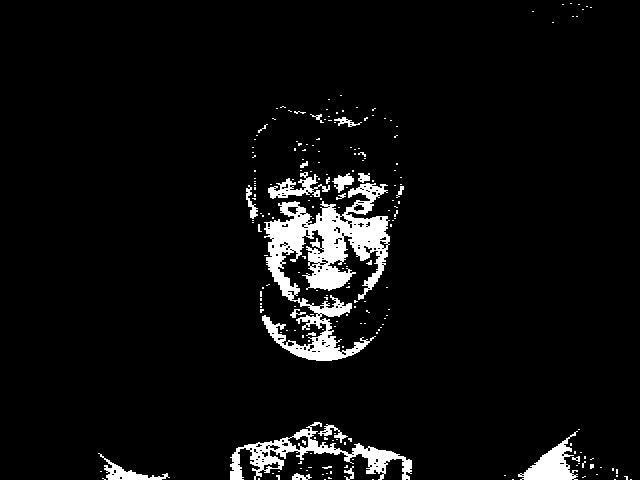

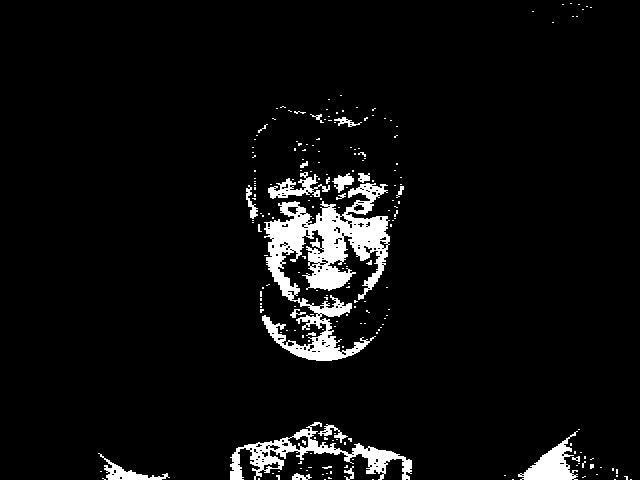

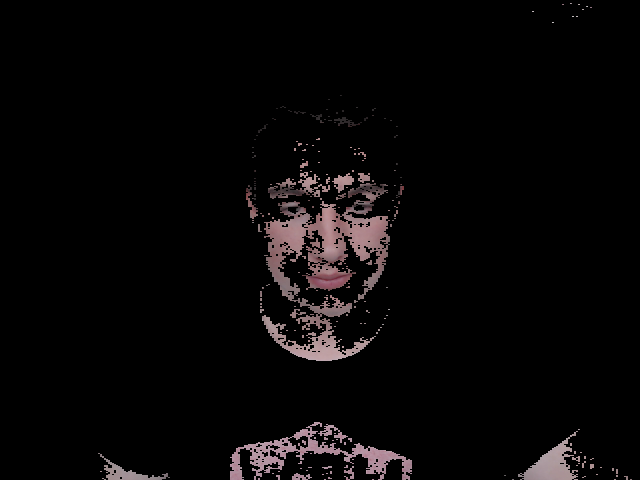

In [ ]:
# Load Haar Cascade for face detection
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Re-open the video
cap = cv2.VideoCapture(video_path)

roi_coords = []  # To store (x, y, w, h) of face ROI per frame

print("Processing video frames for face detection...")

for _ in tqdm(range(frame_count)):
    ret, frame = cap.read()
    if not ret:
        break

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Detect faces in the frame
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(60, 60))

    if len(faces) > 0:
        # Pick the largest face (in case of multiple)
        largest_face = max(faces, key=lambda rect: rect[2] * rect[3])
        roi_coords.append(largest_face)
    else:
        roi_coords.append(None)  # No face found in this frame

cap.release()


**2nd Implementation)** STFT

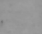

In [ ]:
frame_idx = 0  # change as needed
cap = cv2.VideoCapture(video_path)
cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
ret, frame = cap.read()
cap.release()

if roi_coords[frame_idx] is not None:
    x, y, w, h = roi_coords[frame_idx]
    face_roi = frame[y:y+h, x:x+w]

    plt.figure(figsize=(6, 6))
    plt.imshow(cv2.cvtColor(face_roi, cv2.COLOR_BGR2RGB))
    plt.title(f"Detected Face ROI at Frame {frame_idx}")
    plt.axis('off')
    plt.show()
else:
    print("No face detected in this frame.")


NameError: name 'roi_g' is not defined

100%|██████████| 2032/2032 [00:02<00:00, 689.43it/s] 


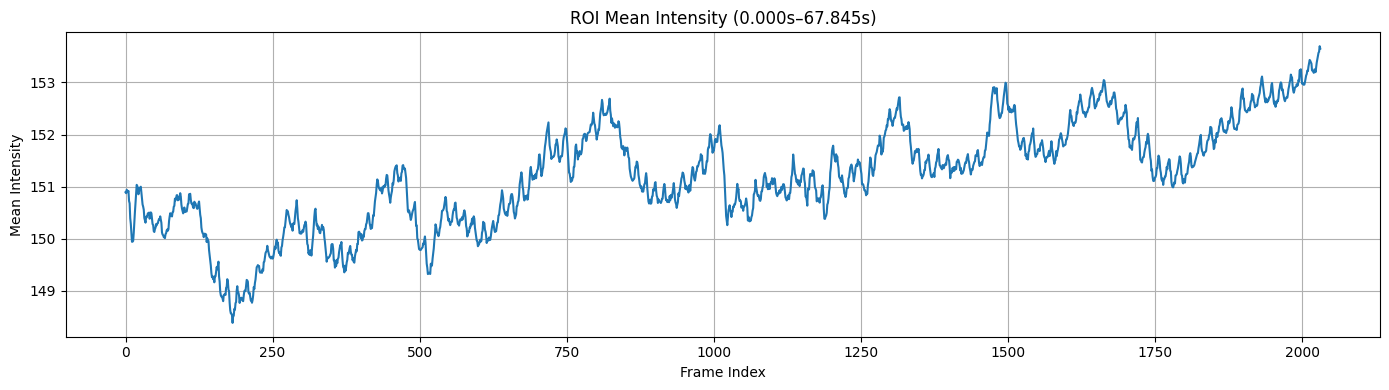

In [7]:
# Input start time and duration (in seconds) for PPG signal plot.
# ----------------------
start_time = 0
segment_duration = video_duration_secs    # Signal lasts video_duration_secs seconds.


# Define ROI coordinates and color channel
y1, y2 = 141, 175
x1, x2 = 305, 347
channel = 1  # Green channel (BGR format)
# ----------------------


end_time = start_time + segment_duration
start_frame = int(start_time * fps)
end_frame = int(end_time * fps)


cap = cv2.VideoCapture(video_path)

fps = cap.get(cv2.CAP_PROP_FPS)
frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

roi_means = []

cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)

for _ in tqdm(range(start_frame, end_frame)):
    ret, frame = cap.read()
    if not ret:
        break

    roi = frame[y1:y2, x1:x2, channel]
    mean_val = np.mean(roi)
    roi_means.append(mean_val)

cap.release()

print()
roi_means = np.array(roi_means)

plt.figure(figsize=(14, 4))
plt.plot(np.arange(start_frame, start_frame + len(roi_means)), roi_means)
plt.title(f"ROI Mean Intensity ({start_time:.3f}s–{end_time:.3f}s)")
plt.xlabel(f"Frame Index")
plt.ylabel("Mean Intensity")
plt.grid(True)
plt.tight_layout()
plt.show()

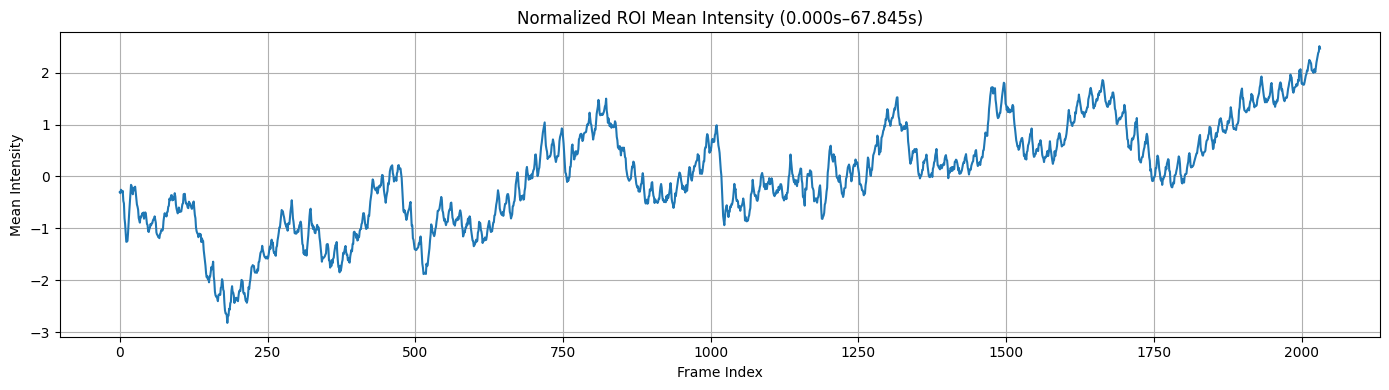

In [8]:
roi_means_norm= (roi_means - np.mean(roi_means)) / np.std(roi_means)

plt.figure(figsize=(14, 4))
plt.plot(np.arange(start_frame, start_frame + len(roi_means)), roi_means_norm)
plt.title(f"Normalized ROI Mean Intensity ({start_time:.3f}s–{end_time:.3f}s)")
plt.xlabel("Frame Index")
plt.ylabel("Mean Intensity")
plt.grid(True)
plt.tight_layout()
plt.show()

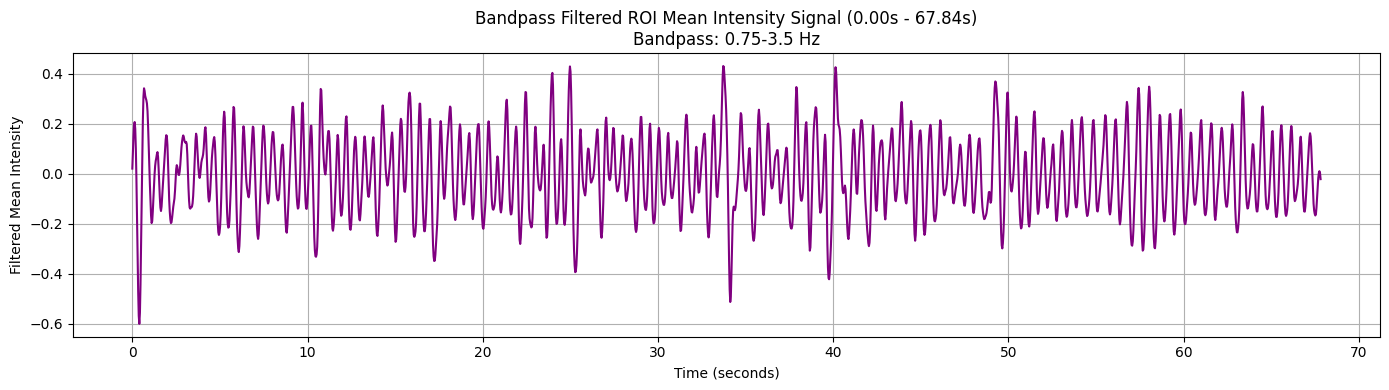

In [9]:
# Input the cutoff frequencies and the order of the bandpass filter.
# ----------------------
lowcut = 0.75
highcut = 3.5

filt_order=1
# ----------------------


def bandpass_filter(data, lowcut, highcut, fs, order=1):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data)


frame_count = len(roi_means_norm)
time = np.arange(frame_count) / fps + start_time

filtered_signal = bandpass_filter(roi_means_norm, lowcut, highcut, fps, filt_order)


plt.figure(figsize=(14, 4))
plt.plot(time, filtered_signal, color='purple')
plt.title(f"Bandpass Filtered ROI Mean Intensity Signal ({start_time:.2f}s - {end_time:.2f}s)\n"
          f"Bandpass: {lowcut}-{highcut} Hz")
plt.xlabel("Time (seconds)")
plt.ylabel("Filtered Mean Intensity")
plt.grid(True)
plt.tight_layout()
plt.show()


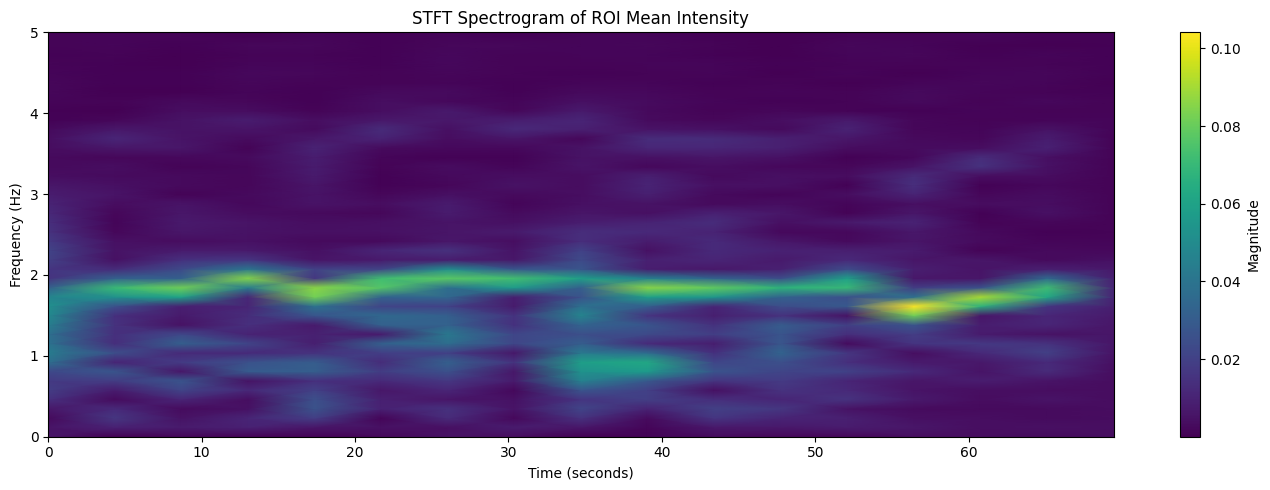

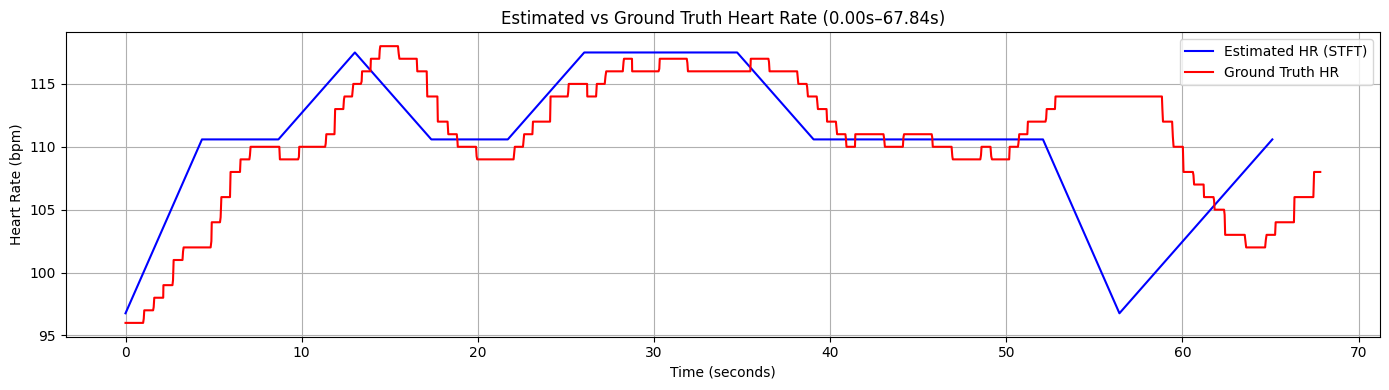

In [32]:
# Input the window parameters for the STFT
# ----------------------
window_size = 260
overlap_ratio = 0.5
# ----------------------

# Apply STFT
f, t, Zxx = stft(filtered_signal,
                 fs=fps,
                 nperseg=window_size,
                 noverlap= int(overlap_ratio * window_size),
                 # boundary=None,
                 # padded=False,
                 )

t = t + start_time
magnitude = np.abs(Zxx)
dominant_freqs = f[np.argmax(magnitude, axis=0)]
dominant_hr = dominant_freqs * 60

valid_idx = t <= end_time
t_valid = t[valid_idx]
dominant_hr_valid = dominant_hr[valid_idx]

start_samp = np.searchsorted(gt_time, start_time)
end_samp = np.searchsorted(gt_time, end_time)

plt.figure(figsize=(14, 5))
plt.pcolormesh(t, f, magnitude, shading='gouraud')
plt.title("STFT Spectrogram of ROI Mean Intensity")
plt.xlabel("Time (seconds)")
plt.ylabel("Frequency (Hz)")
plt.colorbar(label='Magnitude')
plt.ylim(0, 5)
plt.tight_layout()
plt.show()

plt.figure(figsize=(14, 4))
plt.plot(t_valid, dominant_hr_valid, color='blue', label='Estimated HR (STFT)')
plt.plot(gt_time[start_samp:end_samp], gt_hr[start_samp:end_samp], color='red', label='Ground Truth HR')
plt.title(f"Estimated vs Ground Truth Heart Rate ({start_time:.2f}s–{end_time:.2f}s)")
plt.xlabel("Time (seconds)")
plt.ylabel("Heart Rate (bpm)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

100%|██████████| 14/14 [00:00<00:00, 1705.60it/s]


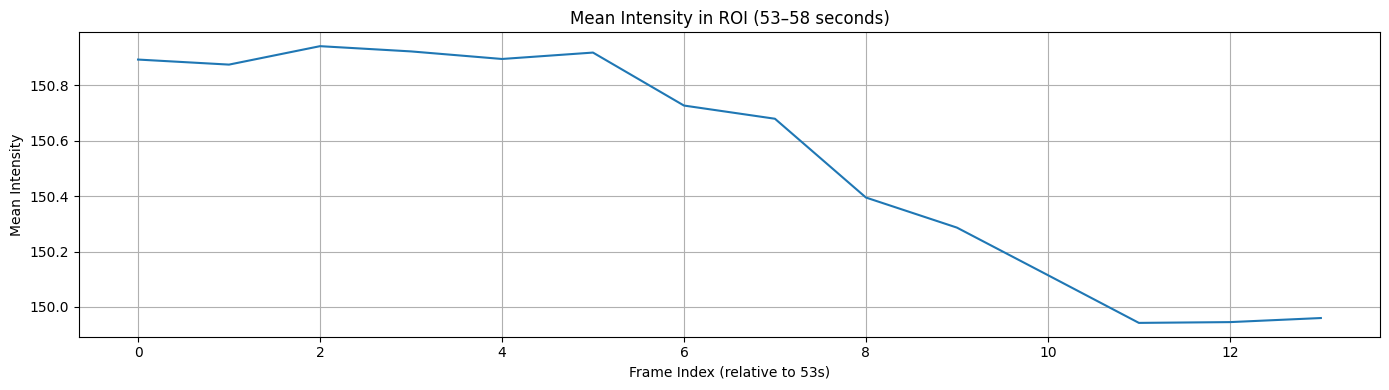

In [ ]:

# Reopen the video
cap = cv2.VideoCapture(video_path)

fps = cap.get(cv2.CAP_PROP_FPS)
frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

# Define time segment (in seconds)
start_time_sec = 0
end_time_sec = 0.5

# Convert time to frame indices
start_frame = int(start_time_sec * fps)
end_frame = int(end_time_sec * fps)

# Define ROI coordinates and color channel
y1, y2 = 141, 175
x1, x2 = 305, 347
channel = 1  # Green channel (BGR format)

roi_means = []

# Set video to start at the desired frame
cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)

for _ in tqdm(range(start_frame, end_frame)):
    ret, frame = cap.read()
    if not ret:
        break

    roi = frame[y1:y2, x1:x2, channel]
    mean_val = np.mean(roi)
    roi_means.append(mean_val)

cap.release()

# Convert to NumPy array
roi_means = np.array(roi_means)

# Plot the ROI mean signal
plt.figure(figsize=(14, 4))
plt.plot(roi_means, label='ROI Mean (53–58s)')
plt.title("Mean Intensity in ROI (53–58 seconds)")
plt.xlabel("Frame Index (relative to 53s)")
plt.ylabel("Mean Intensity")
plt.grid(True)
plt.tight_layout()
plt.show()


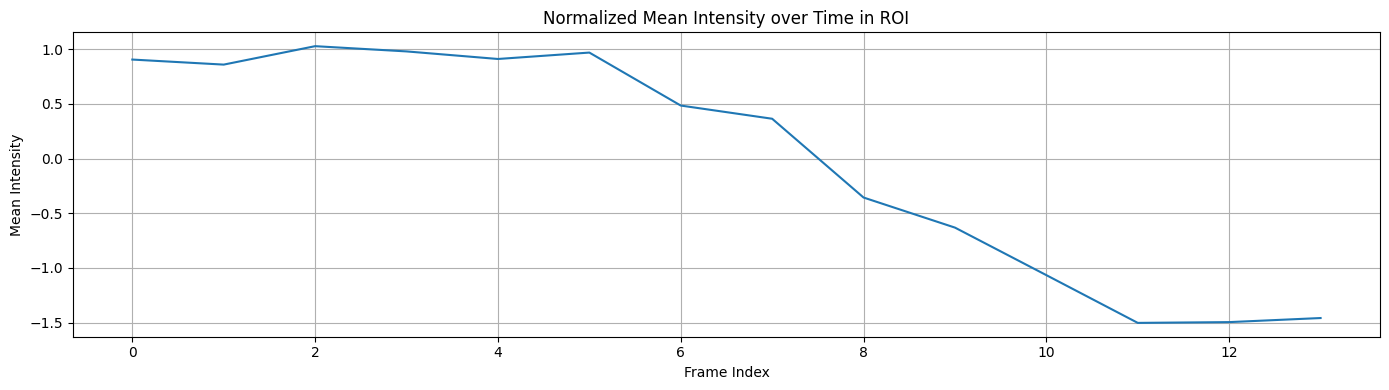

In [ ]:
roi_means_norm= (roi_means - np.mean(roi_means)) / np.std(roi_means)

plt.figure(figsize=(14, 4))
plt.plot(roi_means_norm, label='Normalized ROI Mean')
plt.title("Normalized Mean Intensity over Time in ROI")
plt.xlabel("Frame Index")
plt.ylabel("Mean Intensity")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
fs = 29.951                # frame rate from video  # normalized ROI mean intensity

# --- Bandpass filter function ---
def bandpass_filter(data, lowcut, highcut, fs, order=1):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data)

# --- Prepare indices ---
frame_count = len(roi_means_norm)
time = np.arange(frame_count) / fs


# --- Filter parameters ---
lowcut = 0.75   # Hz, approx. 45 bpm
highcut = 3.5   # Hz, approx. 210 bpm

# --- Apply bandpass filter on whole signal (optional) or on segment ---
filtered_signal = bandpass_filter(roi_means_norm, lowcut, highcut, fs, order=4)

# --- Plot filtered segment ---
plt.figure(figsize=(14, 4))
plt.plot(time, filtered_signal, color='purple')
plt.title(f"Bandpass Filtered ROI Signal\n"
          f"Bandpass: {lowcut}-{highcut} Hz")
plt.xlabel("Time (seconds)")
plt.ylabel("Filtered Amplitude")
plt.grid(True)
plt.tight_layout()
plt.show()


ValueError: The length of the input vector x must be greater than padlen, which is 27.

In [ ]:
# --- Extract only the filtered portion you're analyzing ---
segment = filtered_signal # roi_means_norm
n = len(segment)

# --- FFT ---
yf = fft(segment)
xf = fftfreq(n, d=1/fs)  # Frequency bins (Hz)

# --- Only keep positive frequencies ---
idxs = np.where(xf > 0)
xf = xf[idxs]
yf = np.abs(yf[idxs])

# --- Optional: focus on HR-relevant frequency band ---
mask = (xf >= 0.75) & (xf <= 3.5)
xf_hr = xf[mask]
yf_hr = yf[mask]

# --- Plot FFT spectrum ---
plt.figure(figsize=(12, 4))
plt.plot(xf_hr, yf_hr, color='teal')
plt.title("FFT of Bandpass Filtered Signal (Frequency Domain)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Estimate HR (in bpm) from peak frequency ---
peak_freq = xf_hr[np.argmax(yf_hr)]
heart_rate_bpm = peak_freq * 60
print(f"Estimated Heart Rate: {heart_rate_bpm:.2f} bpm")


NameError: name 'filtered_signal' is not defined